importing libraries

In [136]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action="once")
warnings.filterwarnings(action="ignore")
%matplotlib inline
from datetime import datetime

#import modelling libraries
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import LinearSVR, SVR, NuSVR
from sklearn.compose import make_column_transformer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, PolynomialFeatures

# loading the data

In [137]:
data=pd.read_csv('/content/second_hand_cars.csv')

In [125]:
data.head()

,Company Name,Car Name,Variant,Fuel Type,Tyre Condition,Owner Type,Mileage,Price,Transmission Type,Body Color,Insurance,Registration Certificate,Accessories,Last Service Mileage,Car Age,Car Age Category,Price per mileage
0,Maruti Suzuki,Cruze,EX,CNG,Needs Replacement,Second,52798,759107,Manual,Grey,No Current Insurance,Not Available,"Music System, Sunroof, Alloy Wheels",50418.0,6,Old,14.377571
1,Kia,Seltos,RXE,Petrol,New,Third,43412,505071,Automatic,Maroon,No Current Insurance,Available,Leather Seats,131313.0,4,Recent,11.634364
2,Kia,Accord,RXE,Petrol,New,Second,95219,635322,Automatic (Tiptronic),Black,No Current Insurance,Available,GPS,0.0,2,New,6.672219
3,Nissan,Seltos,Highline,Diesel,Used,Third,70370,483152,Automatic (Tiptronic),Maroon,Valid Until [date],Available,"Music System, Alloy Wheels",98115.0,0,New,6.865880
4,Chevrolet,Kwid,Highline,Petrol,Used,Second,85852,712961,Automatic (Tiptronic),Silver,No Current Insurance,Not Available,"GPS, Music System",135665.0,6,Old,8.304536


In [5]:
data.shape

(2500, 16)

# Data cleaning

In [109]:
data.isnull().sum().sort_values(ascending=np.False_)

Accessories                 482
Variant                     262
Company Name                  0
Car Name                      0
Fuel Type                     0
Tyre Condition                0
Make Year                     0
Owner Type                    0
Registration Number           0
Mileage                       0
Price                         0
Transmission Type             0
Body Color                    0
Service Record                0
Insurance                     0
Registration Certificate      0
dtype: int64

<Axes: >

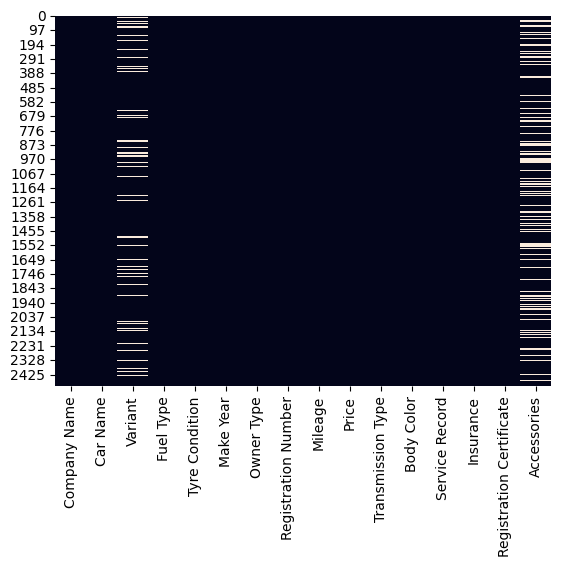

In [19]:
sns.heatmap(data.isnull(), cbar=False)

The variant and accessory columns are missing some values. We can fill this missingness by grouping the cars according to the company name and car name and missingness the missing values with the mode of these two categories.

In [138]:
#filling the missingness in the variant feature with the mode of similar cars
data['Variant'] = data.groupby(['Company Name', 'Car Name'])['Variant'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else 'Unknown'))
#filling the missing values of the accessories column with the mode of car with a similar company name and make years
data['Accessories'] = data.groupby(['Company Name', 'Make Year'])['Accessories'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else 'Unknown'))

In [141]:
#dropping any unique identifiers
data=data.drop('Registration Number', axis=1)

In [142]:
#checking for duplicates
data.duplicated().sum()

0

## Exploratory Data Analysis(EDA)

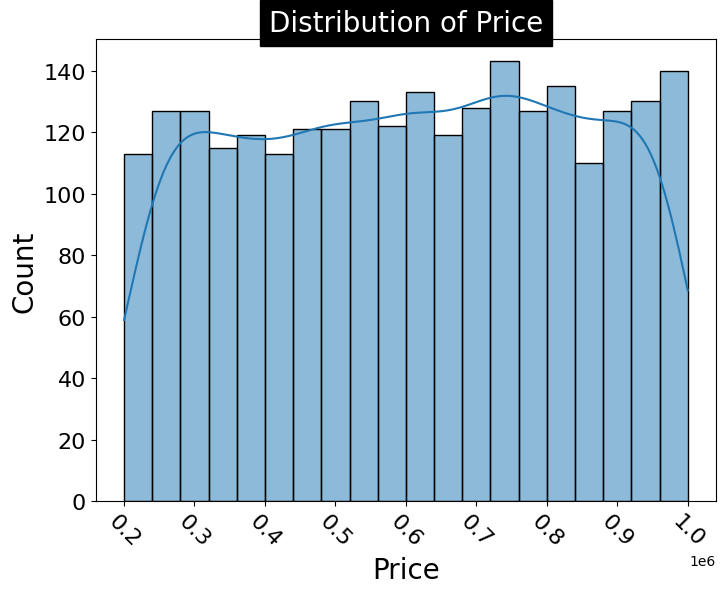

In [143]:
plt.figure(figsize=(8, 6))
# Create a histogram of the 'Price' column with specified bins and kde
sns.histplot(data["Price"], bins=20, kde=True)
# Add a title to the plot with specified background color, text color, and fontsize
plt.title('Distribution of Price', backgroundcolor='black', color='white', fontsize=20)
# Set x and y axis labels with fontsize
plt.xlabel('Price', fontsize=20)
plt.ylabel('Count', fontsize=20)
# Increase the font size of x and y ticks
plt.xticks(fontsize=16, rotation=-45)
plt.yticks(fontsize=16)
# Display the plot
plt.show()

How do tempral variables(Make year) car features affect the price of the car

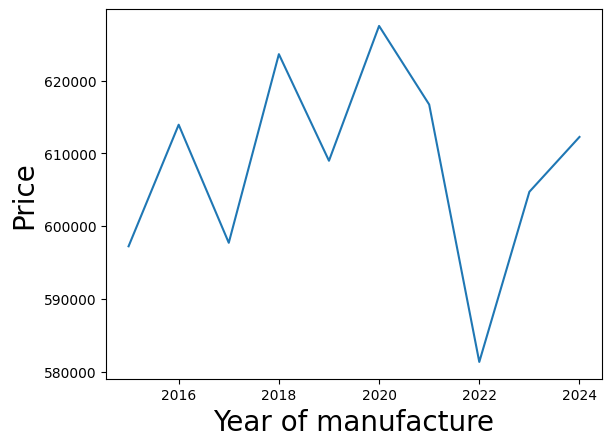

In [144]:
#converting year column to appropriate data type
data['Make Year'] = pd.to_datetime(data['Make Year'], format='%Y').dt.year
#how the make year relates to the price of the car
mean_price_by_year=data.groupby('Make Year')['Price'].mean()
sns.lineplot(x=mean_price_by_year.index, y=mean_price_by_year.values)
plt.xlabel('Year of manufacture', fontsize=20)
plt.ylabel('Price', fontsize=20)
plt.show()


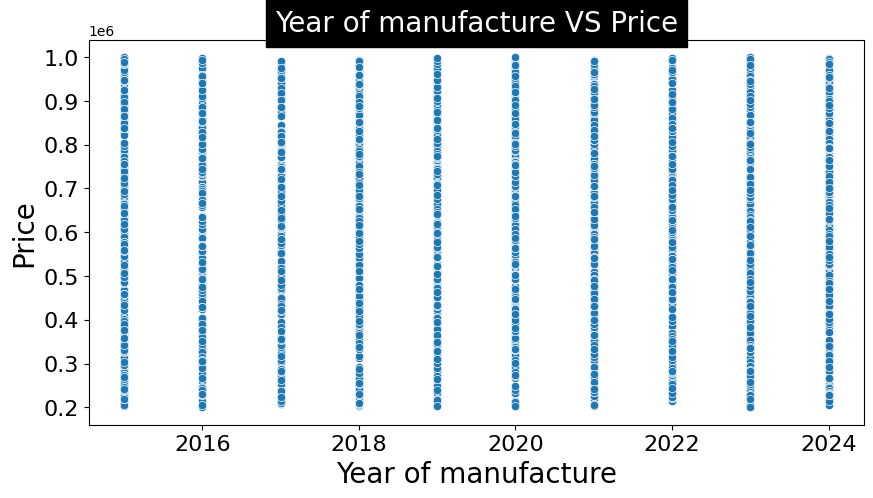

In [145]:
plt.figure (figsize=(10,5), )
# Create a scatter plot
sns.scatterplot(data = data, x = 'Make Year', y = 'Price')
# Add a title to the plot
plt.title('Year of manufacture VS Price',backgroundcolor='black',color='white',fontsize=20)
# Set x and y axis labels with fontsize
plt.xlabel('Year of manufacture', fontsize=20)
plt.ylabel('Price', fontsize=20)
# Increase the font size of x and y ticks
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# Display the plot
plt.show()

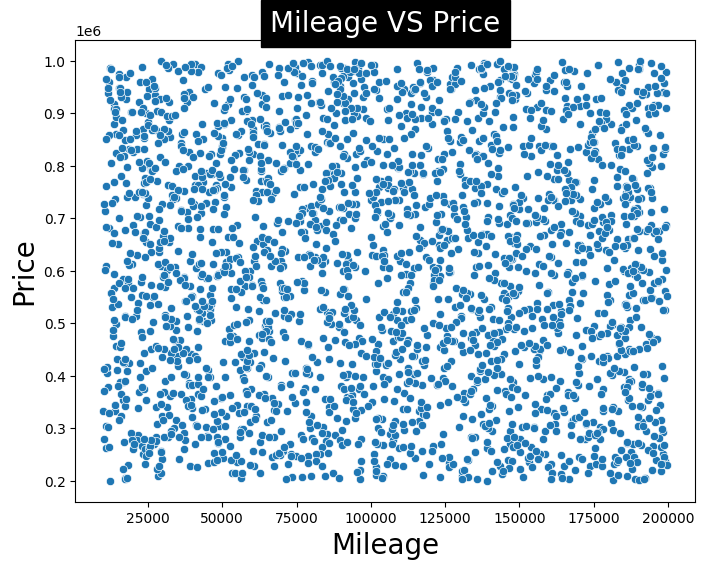

In [146]:
plt.figure (figsize=(8,6))
# Create a scatter plot
sns.scatterplot(data = data, x = 'Mileage', y = 'Price')
# Add a title to the plot
plt.title('Mileage VS Price',backgroundcolor='black',color='white',fontsize=20)
# Set x and y axis labels with fontsize
plt.xlabel('Mileage', fontsize=20)
plt.ylabel('Price', fontsize=20)
# Display the plot
plt.show()

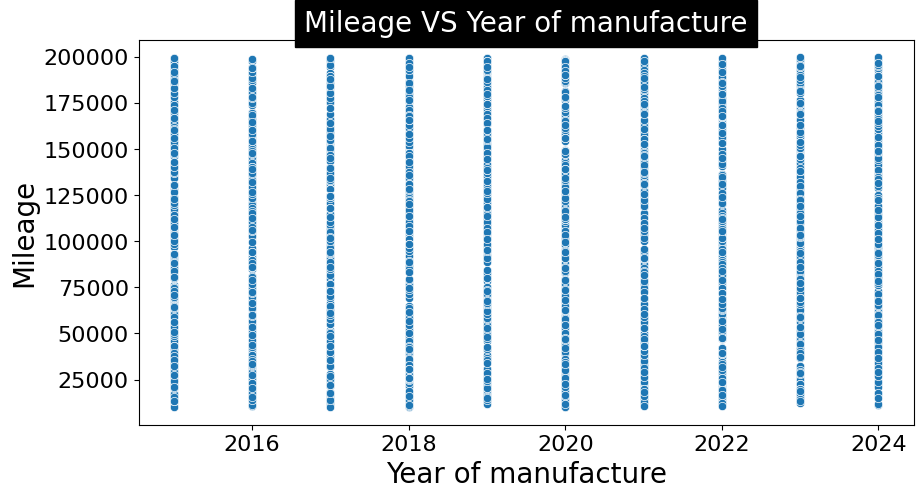

In [147]:
# Set the figure size and DPI
plt.figure (figsize=(10,5))
# Create a scatter plot
sns.scatterplot(data = data, y = 'Mileage', x= 'Make Year')
# Add a title to the plot
plt.title('Mileage VS Year of manufacture',backgroundcolor='black',color='white',fontsize=20)
# Set x and y axis labels with fontsize
plt.xlabel('Year of manufacture', fontsize=20)
plt.ylabel('Mileage', fontsize=20)
# Increase the font size of x and y ticks
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# Display the plot
plt.show()

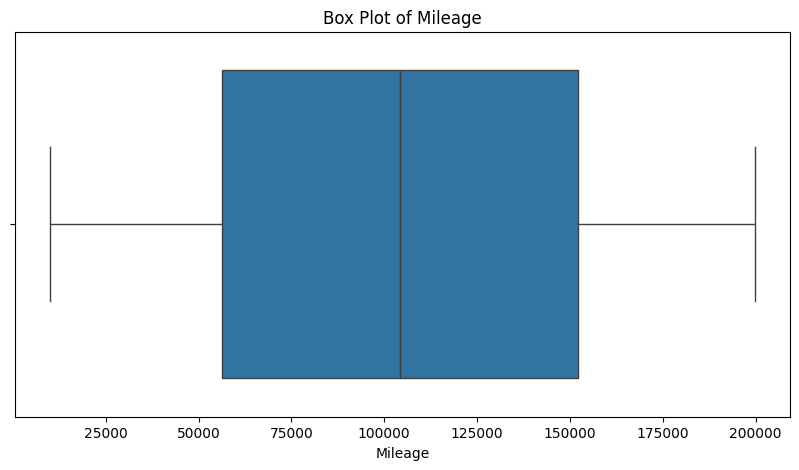

In [148]:

# Box plot for Mileage
plt.figure(figsize=(10, 5))
sns.boxplot(x=data['Mileage'])
plt.title('Box Plot of Mileage')
plt.show()

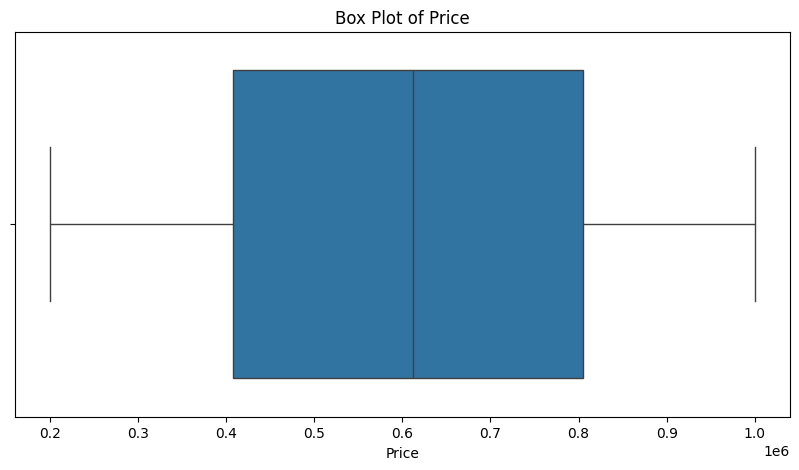

In [133]:
# Box plot for Price
plt.figure(figsize=(10, 5))
sns.boxplot(x=data['Price'])
plt.title('Box Plot of Price')
plt.show()

# observation

There no outliers in the mileag and price features, hence there is no need for outliers handling.

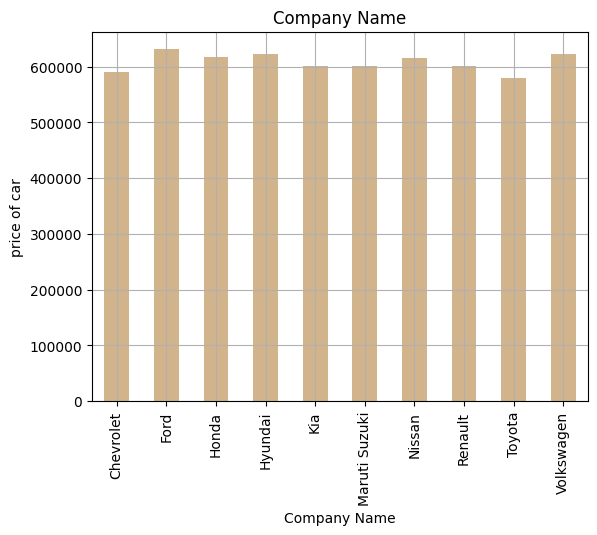

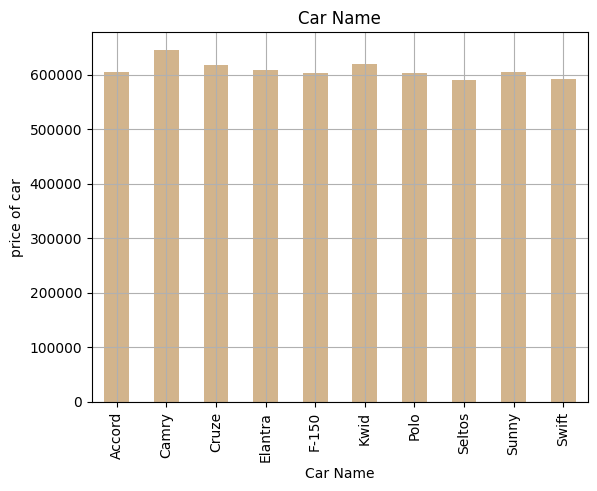

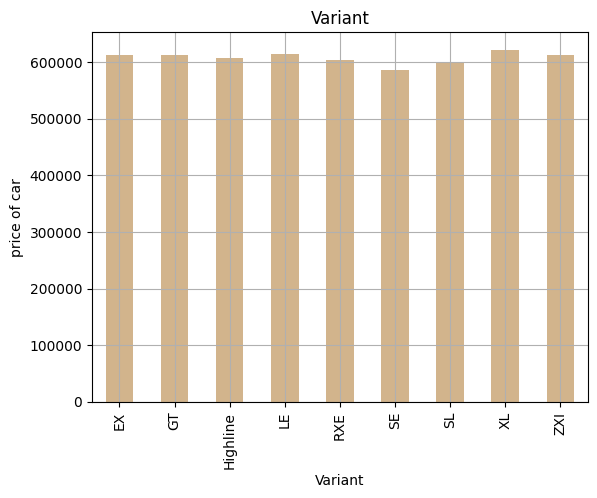

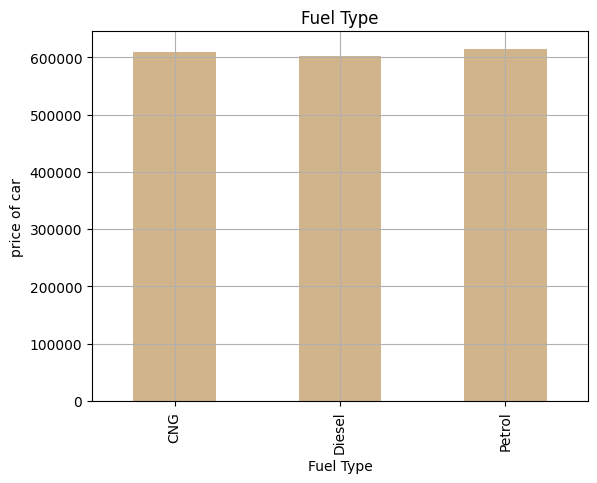

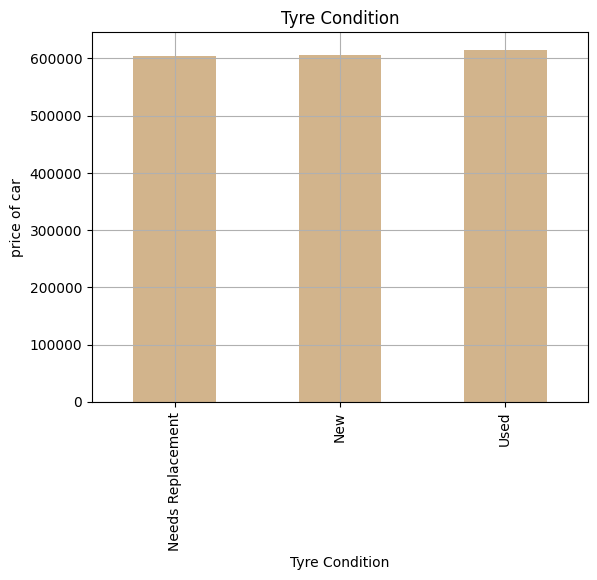

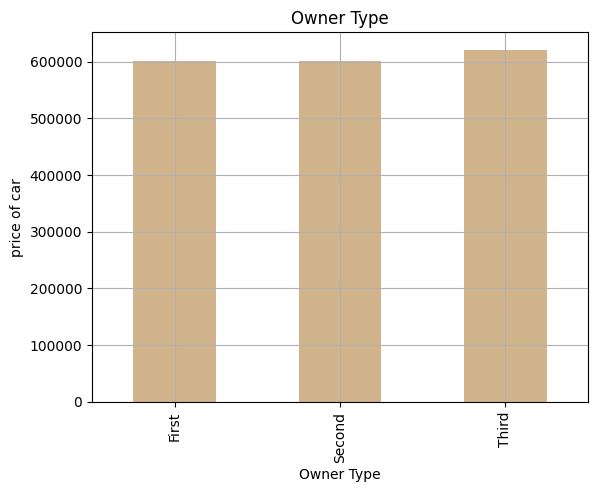

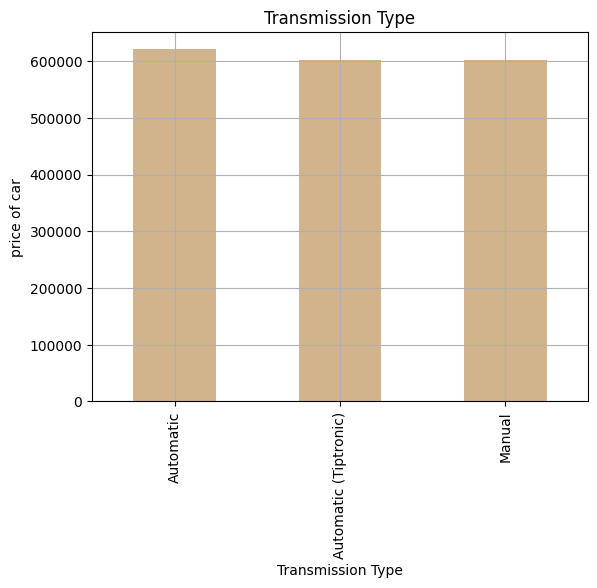

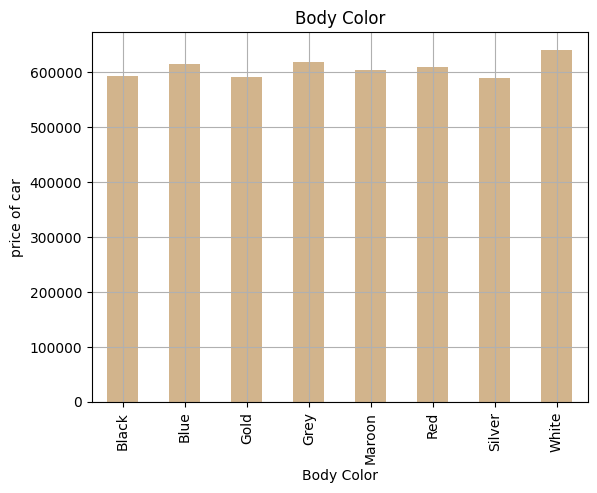

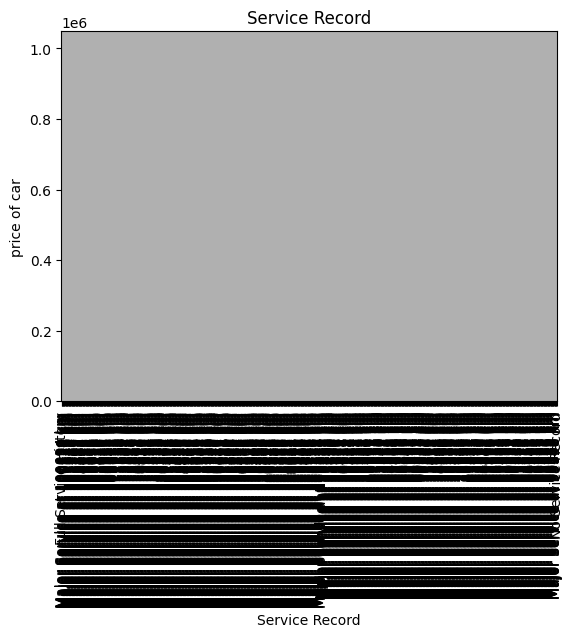

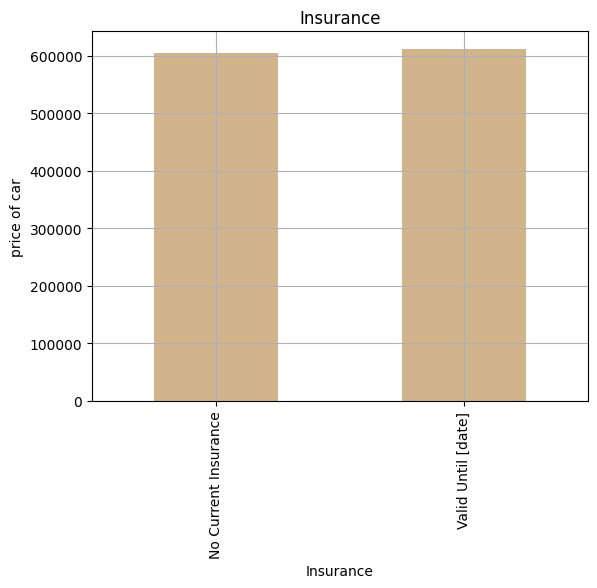

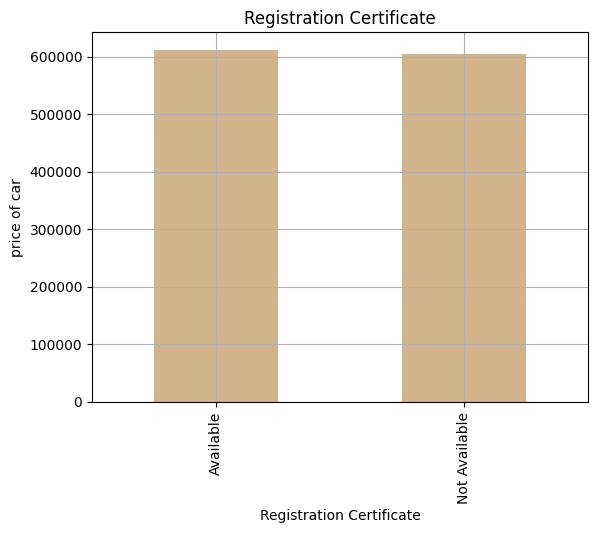

In [151]:

#getting the categorical columns
cat_cols=data.select_dtypes(include='object').columns
for var in cat_cols:
    if not var=='Accessories' and  not var=='Service record':
        data.groupby(var)['Price'].mean().plot.bar(color='tan')
        plt.ylabel('price of car')
        plt.title(var)
        plt.grid(True)
        plt.show()


Automatic cars have a slighlty higher price than the Atomatic(tiptronic) and manual counterparts.

Correlation matrix for the numerical columns

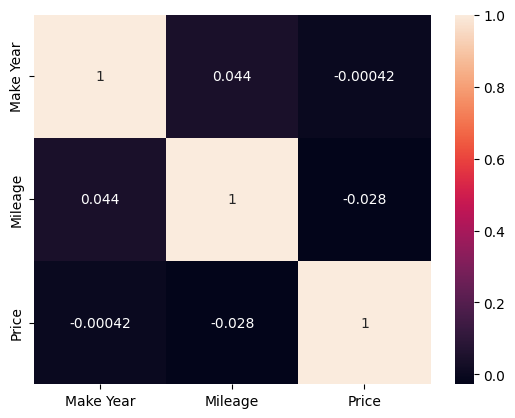

In [152]:
# List of columns for correlation analysis
column_list = [ 'Make Year', 'Mileage', 'Price']
# Create a heatmap of the correlation matrix for the specified columns
sns.heatmap(data[column_list].corr(), annot=True)
# Display the plot
plt.show()

The mileage and make year future and not strongly correlated to target variable.

# Feature Engineering

In [153]:
#mileage at which the last service was done.
data['Last Service Mileage'] = data['Service Record'].str.extract('(\d+)').astype(float)
#filling last service mileage of cars with no service record with 0
data['Last Service Mileage'] = data['Last Service Mileage'].fillna(0)

In [156]:
#age of the car
# Calculate the current year
current_year = datetime.now().year

# Create a new feature 'Car Age'
data['Car Age'] = current_year - data['Make Year']

#classify the cars according to the recency of the model 'new', 'recent', 'old'
def categorize_year(year):
    if year >= current_year - 2:
        return 'New'
    elif year >= current_year - 5:
        return 'Recent'
    else:
        return 'Old'

data['Car Age Category'] = data['Make Year'].apply(categorize_year)

In [157]:
#Price per mileage
data['Price per mileage']=data['Price']/data['Mileage']

In [159]:
#columns to drop
#dropping the make year column
data=data.drop(['Make Year','Service Record'], axis=1)

# **Encoding**

In [169]:
new_data=data.copy()

In [170]:
#the accessories columns hasso many unique values let us drop it
new_data=new_data.drop('Accessories', axis=1)

In [173]:
from pickle import NEWOBJ_EX
#all the categorical columns
categorical_columns=new_data.select_dtypes(include='object').columns
one_hot_encode=OneHotEncoder()
df_encoded=one_hot_encode.fit_transform(new_data[categorical_columns])
df_encoded=pd.DataFrame(df_encoded.toarray(), columns=one_hot_encode.get_feature_names_out(categorical_columns))
# Drop original categorical columns from the original DataFrame
new_data.drop(columns=categorical_columns, inplace=True)
# Concatenate the original DataFrame with the one-hot encoded DataFrame
df_combined = pd.concat([new_data, df_encoded], axis=1)


In [174]:
df_combined.head()

,Mileage,Price,Last Service Mileage,Car Age,Price per mileage,Company Name_Chevrolet,Company Name_Ford,Company Name_Honda,Company Name_Hyundai,Company Name_Kia,...,Body Color_Red,Body Color_Silver,Body Color_White,Insurance_No Current Insurance,Insurance_Valid Until [date],Registration Certificate_Available,Registration Certificate_Not Available,Car Age Category_New,Car Age Category_Old,Car Age Category_Recent
0,52798,759107,50418.0,6,14.377571,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,43412,505071,131313.0,4,11.634364,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,95219,635322,0.0,2,6.672219,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,70370,483152,98115.0,0,6.865880,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
4,85852,712961,135665.0,6,8.304536,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [175]:
#numerical columns
numerical_columns=data.select_dtypes(include='number').columns
#initialize the standrad scaler
standard_scaler=StandardScaler()
#fit and tranform the numerical columns
df_combined[numerical_columns] = standard_scaler.fit_transform(df_combined[numerical_columns])

In [176]:
df_combined.head()

,Mileage,Price,Last Service Mileage,Car Age,Price per mileage,Company Name_Chevrolet,Company Name_Ford,Company Name_Honda,Company Name_Hyundai,Company Name_Kia,...,Body Color_Red,Body Color_Silver,Body Color_White,Insurance_No Current Insurance,Insurance_Valid Until [date],Registration Certificate_Available,Registration Certificate_Not Available,Car Age Category_New,Car Age Category_Old,Car Age Category_Recent
0,-0.936010,0.653591,0.315948,0.525856,0.423144,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,-1.105025,-0.446084,1.908672,-0.165332,0.174142,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,-0.172127,0.117749,-0.676721,-0.856521,-0.276273,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,-0.619588,-0.540968,1.255044,-1.547709,-0.258694,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
4,-0.340800,0.453834,1.994357,0.525856,-0.128107,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


Dimentionality reduction

<Axes: >

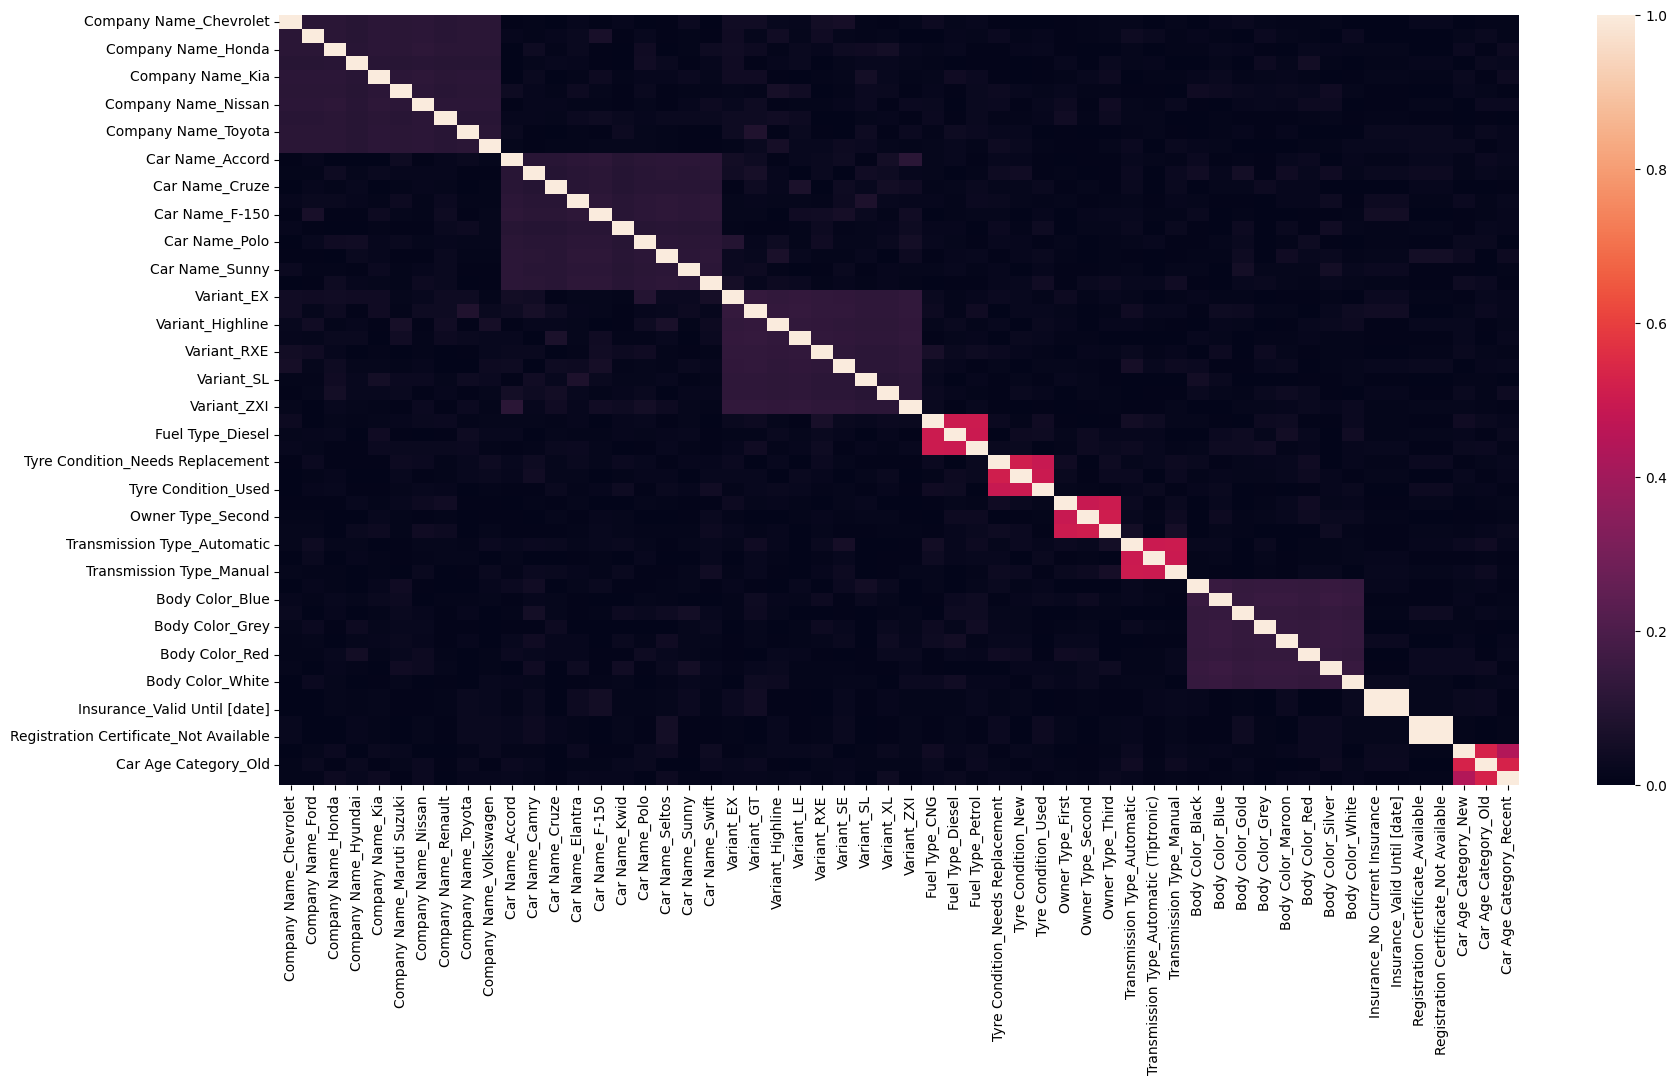

In [177]:
plt.figure(figsize=(20,10))
sns.heatmap(df_encoded.corr().abs())

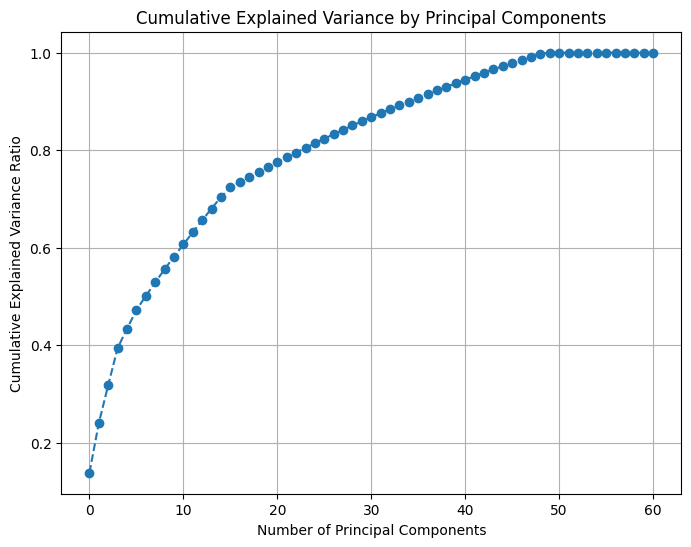

In [184]:
# Apply PCA with more components
pca = PCA().fit(df_combined)

# Plot cumulative explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

In [189]:
# Apply PCA
pca = PCA(n_components=30)  # Adjust n_components as needed
principal_components = pca.fit_transform(df_combined)

# Create a DataFrame with the principal components
# Create a DataFrame with the principal components
df_pca = pd.DataFrame(data=principal_components, columns=[f'Principal Component {i+1}' for i in range(30)])
# Display the PCA DataFrame
print(df_pca.head())

# Explained variance ratio
print("Total Explained Variance: ", np.cumsum(pca.explained_variance_ratio_)[-1])

   Principal Component 1  Principal Component 2  Principal Component 3  \
0               1.212081              -0.591313               0.396304   
1               0.562761               0.472163               1.513667   
2              -0.226465               0.994975              -0.766871   
3              -0.304537               1.799184               0.845648   
4               0.276555              -0.519254               2.092626   

   Principal Component 4  Principal Component 5  Principal Component 6  \
0               0.000701               0.157203               0.930459   
1               1.369727              -0.996010               0.071689   
2              -0.167307              -0.972629               0.107598   
3               1.141603              -0.110432              -0.817317   
4               0.378755               0.175062               0.969845   

   Principal Component 7  Principal Component 8  Principal Component 9  \
0              -0.276508            

# **modelling**

In [193]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [194]:
X = df_pca  # Features after PCA
y=data['Price']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Cross-Validated Modeling

1. **Linear Regression Models:** LinearRegression, Lasso, Ridge, *KernelRidge*
2. **Tree-Based Regression Models:** RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
3. **Ensemble Regression Models:** LinearSVR, SVR, NuSVR, *KernelRidge*

In [196]:
pipe = make_pipeline(PolynomialFeatures(degree=1), LinearRegression())
scores = cross_val_score(pipe, X_train, y_train, cv=10, scoring="r2")
print(scores, scores.mean())

[0.99975239 0.9997812  0.99979036 0.99975261 0.99974034 0.99976555
 0.99975252 0.99977142 0.9997122  0.99979899] 0.9997617574365585


In [198]:
pipe = make_pipeline(PolynomialFeatures(degree=2), Lasso(alpha=0.015))
scores = cross_val_score(pipe, X_train, y_train, cv=10, scoring="r2")

print(scores, scores.mean())

[0.99984973 0.99989601 0.99990564 0.99988153 0.99987577 0.9998726
 0.99989427 0.99988639 0.99988144 0.99991515] 0.9998858543596014


In [201]:
pipe = make_pipeline(PolynomialFeatures(degree=1), Ridge(alpha=100))
scores = cross_val_score(pipe, X, y, cv=10, scoring="r2")
print(scores, scores.mean())

[0.997774   0.99745699 0.99764271 0.99749225 0.99762839 0.99757864
 0.99771398 0.99755561 0.99756106 0.99757196] 0.9975975596970723
